In [1]:
import os
import time
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from absl import flags
from absl import app
from absl import flags
from preprocess import dataloader
from models.builder import process_model
from preprocess.utils import process_predicts, save_inference_time, get_model_path, get_model_path_test_results

FLAGS = flags.FLAGS

title = {
    0: "Classe Animal",
    1: "Classe Vazio",
}

alpha = [title[0], title[1]]

config_filename = "./configs/grad-cam/efficientnetb0_serengeti_(tag_no_serengeti_weights)_256_siamese.config"

In [2]:
def read_config(file_path):
    CONFIG = {}
    lines = []
    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()
            if line and not line.startswith('#'):
                lines.append(line)
                key, value = line.split('=')
                try:
                    value = int(value.strip())
                except Exception:
                    pass
                CONFIG[key.strip().replace('-', '')] = value

    for key in CONFIG:
        t = type(CONFIG[key])
        if t == bool:
            f = flags.DEFINE_bool
        elif t == int:
            f = flags.DEFINE_integer
        else:
            f = flags.DEFINE_string
        f(key, default=CONFIG[key], help='')
    FLAGS(lines)

read_config(config_filename)

In [3]:
model_path = get_model_path()
model_path_results = get_model_path_test_results()
input_size = [FLAGS.image_size, FLAGS.image_size, 3]
model = process_model(
        FLAGS.model_name, 
        input_size,
        FLAGS.num_classes,
        FLAGS.seed
)
model.load_weights(model_path)

model: ../../models/classification/efficientnetb0_siamese_serengeti_(tag_no_serengeti_weights)_256/





In [4]:
data = dataloader.DatasetProcessor(
        csv_file=FLAGS.test_filename,
        output_size=FLAGS.image_size,
        num_classes=FLAGS.num_classes,
        mode='test',
        seed=FLAGS.seed,
        is_training=False,
)
dataset, num_instances, num_classes = data.make_source_dataset()
model.summary()

category
1    3
Name: count, dtype: int64
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input-left (InputLayer)     [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 input-right (InputLayer)    [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 model (Functional)          (None, 128)                  4213539   ['input-left[0][0]',          
                                                                     'input-right[0][0]']         
                                                                                                  
 lambda (Lambda)             (None, 1)            

In [5]:
model.get_layer('model').summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 256, 256, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 256, 256, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, 256, 256, 3)          0         ['normalization[0][0]']   

1/1 [==============================] - 0s 88ms/step
getting Grad-Cam from instances
(8, 8)
(8, 8)
1/1 [==============================] - 0s 97ms/step
getting Grad-Cam from instances
(8, 8)
(8, 8)
1/1 [==============================] - 0s 88ms/step
getting Grad-Cam from instances
(8, 8)
(8, 8)


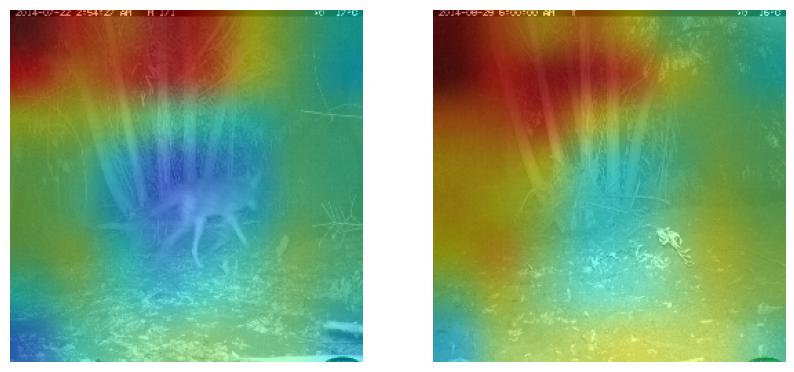

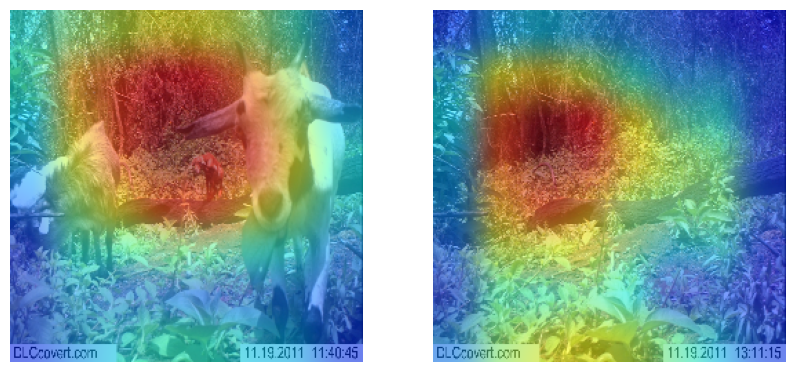

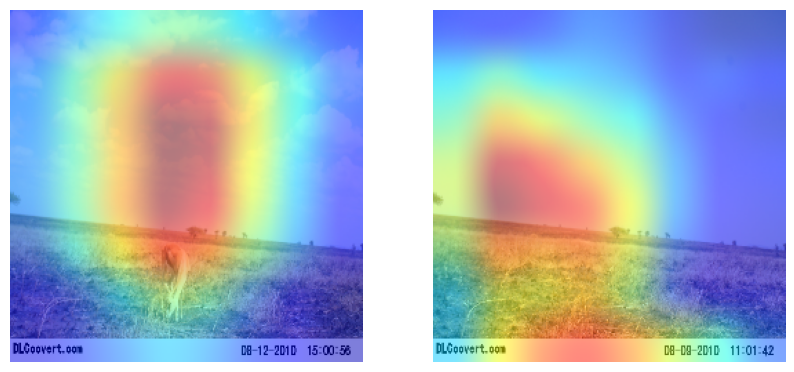

In [8]:
def get_grad_cam_model_layers(model):
    layers = []
    for layer in model.layers:
        if layer.name != "grad-cam":
            layers.append(layer)
        else:
            break
    return layers

def get_grad_cam_model(model):
    base_model = model.get_layer('model')
    return tf.keras.models.Model(
        inputs=[base_model.input],
        outputs=[base_model.get_layer('top_activation').output]
    )
    i = tf.keras.layers.Input([None, None, 3])
    x = base_model(i)
    return tf.keras.models.Model(
        inputs=[i],
        outputs=[base_model.get_layer('top_conv').outputs]
    )
    if FLAGS.model_type == 'siamese':
        backbone_layer = "model"
        for layer in model.layers:
            if "Functional" in str(type(layer)):
                backbone_layer = layer.name
        layers = [model.get_layer('input-left')] + get_grad_cam_model_layers(model.get_layer(backbone_layer))
    else:
        layers = get_grad_cam_model_layers(model)
    return tf.keras.Sequential(layers)

def overlapping_image(img, heatmap, alpha=0.004):
    heatmap = np.uint8(255 * heatmap)
    jet = mpl.colormaps["jet"]
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = tf.keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.utils.img_to_array(jet_heatmap)
    superimposed_img = jet_heatmap * alpha + img
    return tf.keras.utils.array_to_img(superimposed_img)

def show_images(images):
    fig, axes = plt.subplots(1, len(images), figsize=(10, 50))
    for i, ax in enumerate(axes):
        ax.imshow(images[i])
        ax.axis('off')

def make_gradcam_heatmap(instances, model, pred, pred_index=0):
    print("getting Grad-Cam from instances")
    overlapping_images = []
    # show_images(instances)
    for instance in instances:
        with tf.GradientTape() as tape:
            grad_model = get_grad_cam_model(model)
            instance_model = tf.expand_dims(instance, axis=0)
            last_conv_layer_output = grad_model(instance_model)

        pooled_grads = tf.reduce_mean(last_conv_layer_output, axis=(0, 1, 2))
        last_conv_layer_output = last_conv_layer_output[0]
        heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
        heatmap = tf.squeeze(heatmap)
        heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
        heatmap = heatmap.numpy()
        print(heatmap.shape)
        overlapping_images.append(overlapping_image(instance, heatmap))
    show_images(overlapping_images)


for batch in dataset:
    if FLAGS.model_type == 'siamese':
        images_left, images_right = batch[0][0], batch[0][1]
        for pair in zip(images_left, images_right):
            pred = model.predict([images_left, images_right])
            make_gradcam_heatmap(pair, model, pred)
    else:
        for instance in batch[0]:
            make_gradcam_heatmap([instance], model)

In [ ]:
one_dimensional_array = np.array([0.1, 0.5, 0.8, 0.3, 0.6, 0.9, 0.2, 0.4, 0.7, 0.2, 0.6, 0.1, 0.4, 0.8, 0.3, 0.5])


In [ ]:
1280/20

64.0

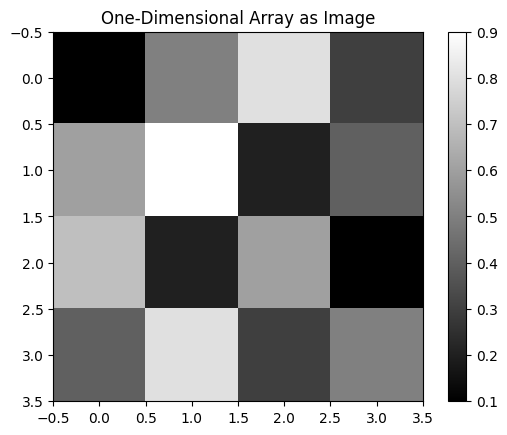

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define dimensions of the image
width = 8  # Number of columns
height = 4  # Number of rows

# Create a one-dimensional NumPy array (example grayscale pixel values)
one_dimensional_array = np.array([0.1, 0.5, 0.8, 0.3, 0.6, 0.9, 0.2, 0.4, 0.7, 0.2, 0.6, 0.1, 0.4, 0.8, 0.3, 0.5])

# Reshape the one-dimensional array to a two-dimensional array (image shape)
image_array = one_dimensional_array.reshape((4, 4))

# Plot the image
plt.imshow(image_array, cmap='gray')  # cmap='gray' for grayscale image
plt.title('One-Dimensional Array as Image')
plt.colorbar()  # Show colorbar for intensity scale
plt.show()
